<a href="https://colab.research.google.com/github/zackives/upenn-cis-2450/blob/main/Lab_5_Part_1_Advanced_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 2450 Lab 5 Part 1: Advanced SQL

## Introduction

Welcome to Lab 5 of CIS 2450! Building upon the SQL foundations from Lab 3, we'll now dive into more advanced SQL concepts and complex queries. This lab aims to enhance your SQL skills and develop your problem-solving approach for intricate data analysis tasks.

### Key Topics

1. **Window Functions**
2. **Aggregate Window Functions**
3. **Advanced Grouping Operations**
4. **Step-by-Step Problem Solving with CTEs**

### Why Advanced SQL Matters

As data a data scientist, advanced SQL skills enable you to:
- Extract deep insights from complex datasets
- Perform sophisticated time-series analysis
- Create advanced calculations like running totals and moving averages
- Optimize queries for large-scale data processing

### Learning Objectives

By the end of this lab, you should be able to:

1. Write and understand complex SQL queries using window functions
2. Effectively manipulate complex grouping
3. Apply aggregate functions over sliding windows
4. Break down and solve complex problems using CTEs
5. Combine multiple SQL concepts to solve intricate data analysis tasks

Let's dive in and elevate your SQL skills to tackle complex data challenges!

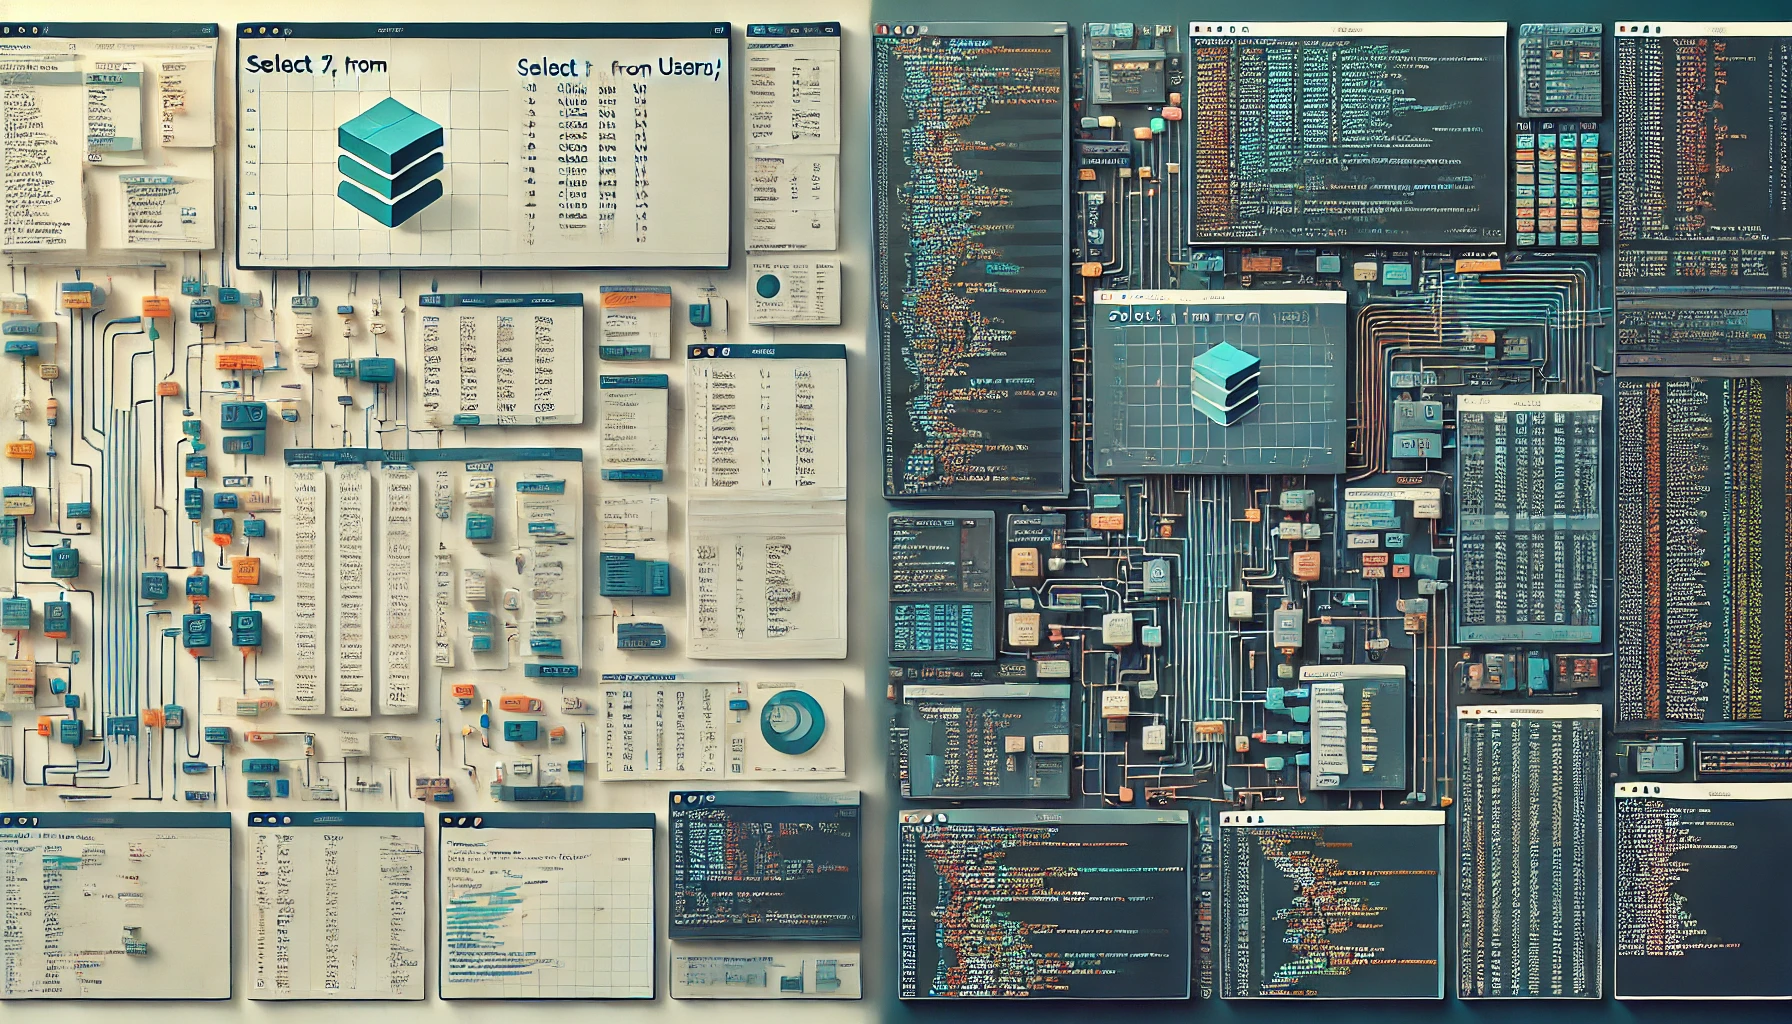

In [ ]:
!pip3 install duckdb

In [ ]:
import duckdb
import numpy as np
import pandas as pd

### Dataset

We'll continue using DuckDB for this lab. The syntax we'll learn is very similar to what you'd use in Spark environment.

We'll work with a custom dataset simulating a real-world scenario, consisting of three main tables:

1. **user_info**: Contains user details like ID, achievement level, and registration time. (Download [Here](https://drive.google.com/file/d/1foAi2XMle817DP4ZystmKGz20fzbpH3-/view?usp=drive_link)!)
2. **examination_info**: Stores exam metadata including exam ID, tag, difficulty, and release time. (Download [Here](https://drive.google.com/file/d/1E2P9f0Fng71ZbHSTUUle6N7BAp2HvGR8/view?usp=drive_link)!)
3. **exam_record**: Records exam attempts with start time, submit time, and scores. (Download [Here](https://drive.google.com/file/d/1SLCThmTrou0-elOCGpMfFuKFrL_QBNws/view?usp=sharing)!)

In [ ]:
user_info = pd.read_csv('user_info.csv')
user_info.head()

,id,uid,achievement_level,job,register_time
0,1,1001,34,DevOps,2022-03-18 19:32:45
1,2,1002,39,Data Analyst,2022-05-06 10:46:26
2,3,1003,10,Web Dev,2022-04-11 10:51:17
3,4,1004,73,Data Science,2022-02-02 14:17:16
4,5,1005,36,Algorithm,2022-08-08 05:18:17


In [ ]:
examination_info = pd.read_csv('examination_info.csv')
examination_info.head()

,id,exam_id,tag,difficulty,duration,release_time
0,1,9001,Java,easy,69,2022-02-24 12:00:58
1,2,9002,System Design,hard,38,2022-12-18 11:57:33
2,3,9003,Python,hard,36,2022-12-01 15:30:26
3,4,9004,SQL,hard,104,2022-08-25 17:41:50
4,5,9005,Algorithm,easy,90,2022-04-30 14:59:52


In [ ]:
exam_record = pd.read_csv('exam_record.csv')
exam_record.head()

,id,uid,exam_id,start_time,submit_time,score
0,1,1018,9012,2022-08-11 07:48:28,2022-08-11 10:46:28,43.0
1,2,1040,9012,2022-09-03 11:31:27,NaN,NaN
2,3,1003,9005,2022-03-07 18:11:36,2022-03-07 19:18:36,3.0
3,4,1002,9009,2022-11-08 18:51:27,2022-11-08 21:08:27,32.0
4,5,1017,9014,2022-12-26 13:11:20,NaN,NaN


## Window Functions

### Why Window Functions

Window functions are a powerful feature in SQL that allow us to perform calculations across a set of rows that are related to the current row. They provide a way to do complex analyses that would be difficult or impossible with a simple GROUP BY. While GROUP BY is excellent for aggregating data, it has limitations when we want to:

- Perform calculations that require access to more than just the aggregated values
- Include non-aggregate rows alongside aggregated results
- Compute running totals, moving averages, or rankings

Let's look at an example: Suppose we want to find out how many exams each user has taken, but we **also** want to see the details of their most recent exam.

In [ ]:
# This query will give us the count of exams per user, but not the
# details of their latest exam
query_group_by = '''
SELECT uid, COUNT(*) as exam_count
FROM exam_record
GROUP BY uid
'''
result_group_by = duckdb.sql(query_group_by).df()
result_group_by.head()

,uid,exam_count
0,1018,28
1,1017,19
2,1016,20
3,1007,23
4,1037,12


Window functions follow this general structure:

```sql
function_name(args) OVER (
    [PARTITION BY column1, column2, ...]
    [ORDER BY column3, column4, ...]
    [ROWS or RANGE frame_clause]
)
```

Let's break this down:

1. `function_name(args)`: The calculation to be performed, such as COUNT(*) or MAX(score).

2. `OVER`: Indicates the start of the window specification.

3. `PARTITION BY`: Divides the result set into groups. The function is calculated separately for each group.

4. `ORDER BY`: Determines the order of rows within each partition for calculation purposes.

5. `ROWS or RANGE`: Specifies which rows to include in the calculation relative to the current row.


For example:

```sql
SELECT
    uid,
    exam_id,
    score,
    COUNT(*) OVER (PARTITION BY uid) as total_exams
FROM exam_record
ORDER BY uid, exam_id
```

In this query:
- `COUNT(*) OVER (PARTITION BY uid)` counts the total exams for each user.
- The result includes individual exam details along with the count.

We'll cover the following window functions:

1. Ranking functions
2. Aggregate functions
3. Offset functions

### Ranking Functions

Ranking functions assign a position to each row within a partition of a result set. They are particularly useful for creating top-N lists, identifying unique rows, and handling ties in data.

- **ROW_NUMBER()**:
   - Assigns a unique number to each row.
   - Always produces a sequence of consecutive integers.

- **RANK()**:
   - Assigns the same rank to ties.
   - Skips the next rank(s) after ties.

- **DENSE_RANK()**:
   - Assigns the same rank to ties.
   - Does not skip ranks after ties.

Let's explore these functions using a consistent example:

In [ ]:
query_rank = '''
SELECT
    uid,
    score,
    ROW_NUMBER() OVER (ORDER BY score DESC) as row_num,
    RANK() OVER (ORDER BY score DESC) as rank,
    DENSE_RANK() OVER (ORDER BY score DESC) as dense_rank
FROM exam_record
LIMIT 15
'''
result_rank = duckdb.sql(query_rank).df()
result_rank

,uid,score,row_num,rank,dense_rank
0,1042,100.0,1,1,1
1,1033,100.0,2,1,1
2,1002,100.0,3,1,1
3,1014,100.0,4,1,1
4,1017,100.0,5,1,1
5,1033,100.0,6,1,1
6,1007,100.0,7,1,1
7,1010,99.0,8,8,2
8,1045,99.0,9,8,2
9,1001,99.0,10,8,2


#### Example: Highest Scores

This example finds the top 3 performers for each exam category.

In [ ]:
query_hs = '''
WITH user_scores AS (
    SELECT
        ei.tag,
        er.uid,
        MAX(er.score) AS max_score
    FROM exam_record er
    JOIN examination_info ei ON er.exam_id = ei.exam_id
    GROUP BY ei.tag, er.uid
),
ranked_scores AS (
    SELECT
        tag,
        uid,
        max_score,
        ROW_NUMBER() OVER (
            PARTITION BY tag
            ORDER BY max_score DESC
        ) AS ranking
    FROM user_scores
)
SELECT tag, uid, max_score, ranking
FROM ranked_scores
WHERE ranking <= 3
ORDER BY tag, ranking
'''

result_hs = duckdb.sql(query_hs).df()
result_hs

,tag,uid,max_score,ranking
0,Algorithm,1014,100.0,1
1,Algorithm,1012,99.0,2
2,Algorithm,1010,99.0,3
3,Data Structure,1007,100.0,1
4,Data Structure,1042,100.0,2
5,Data Structure,1010,99.0,3
6,Java,1002,100.0,1
7,Java,1024,99.0,2
8,Java,1031,97.0,3
9,Machine Learning,1017,100.0,1


Key Differences:

- **Handling Ties**:
  - ROW_NUMBER() always gives different numbers, even for tied values.
  - RANK() and DENSE_RANK() give the same rank for tied values.

- **Gaps in Sequence**:
  - ROW_NUMBER() never has gaps.
  - RANK() has gaps after ties.
  - DENSE_RANK() never has gaps.

### Aggregate Functions

Aggregate functions like SUM(), AVG(), COUNT(), MIN(), and MAX() can be used with window functions to perform calculations across a set of rows that are related to the current row.

When used with OVER(), these functions can compute **cumulative or moving aggregates, compare individual rows to group statistics, or perform complex calculations**.

#### Example: Min-Max Scaling

We'll scale the scores for hard exams to a range of [0, 100] for each exam.

In [ ]:
query_minmax = '''
WITH hard_exams AS (
    SELECT er.uid, er.exam_id, er.score
    FROM exam_record er
    JOIN examination_info ei ON er.exam_id = ei.exam_id
    WHERE ei.difficulty = 'hard'
),
score_ranges AS (
    SELECT
        *,
        MIN(score) OVER (PARTITION BY exam_id) AS min_score,
        MAX(score) OVER (PARTITION BY exam_id) AS max_score
    FROM hard_exams
)
SELECT
    uid,
    exam_id,
    CASE
        WHEN max_score = min_score THEN score
        ELSE (score - min_score) * 100.0 / (max_score - min_score)
    END AS scaled_score
FROM score_ranges
ORDER BY exam_id ASC, scaled_score DESC
'''

result_minmax = duckdb.sql(query_minmax).df()
result_minmax.head(10)

,uid,exam_id,scaled_score
0,1041,9002,100.000000
1,1044,9002,100.000000
2,1020,9002,97.938144
3,1039,9002,97.938144
4,1030,9002,95.876289
5,1050,9002,93.814433
6,1002,9002,89.690722
7,1002,9002,87.628866
8,1042,9002,86.597938
9,1041,9002,83.505155


#### Example: Moving Average

We would calculate a 3-exam moving average of scores for user 1001, only keeping the exams where 1001 attempted more than three times.

In [ ]:
query_moving_avg = '''
WITH user_exams AS (
    SELECT
        uid,
        exam_id,
        score,
        start_time,
        COUNT(*) OVER (PARTITION BY exam_id) as attempt_count,
        COUNT(*) OVER (PARTITION BY exam_id ORDER BY start_time) as attempt,
        AVG(score) OVER (
            PARTITION BY exam_id
            ORDER BY start_time
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ) AS moving_avg_score
    FROM exam_record
    WHERE uid = '1001'
)
SELECT
    uid,
    exam_id,
    attempt,
    score,
    ROUND(moving_avg_score, 2) as moving_avg_score
FROM user_exams
WHERE attempt_count >= 3
ORDER BY exam_id, attempt
'''

result = duckdb.sql(query_moving_avg).df()
result.head(12)

,uid,exam_id,attempt,score,moving_avg_score
0,1001,9002,1,33.0,33.0
1,1001,9002,2,15.0,24.0
2,1001,9002,3,54.0,34.0
3,1001,9002,4,78.0,49.0


### Offset Functions

Offset functions allow you to access data from other rows **in relation to the current row** within a partition. The two main offset functions are LAG and LEAD.

**LAG** accesses data from a previous row in the result set.


```sql
LAG(column, offset, default) OVER (PARTITION BY ... ORDER BY ...)
```

**LEAD** accesses data from a subsequent row in the result set.

```sql
LEAD(column, offset, default) OVER (PARTITION BY ... ORDER BY ...)
```

- `column`: The column to retrieve the value from
- `offset`: How many rows back/forward to look (default is 1)
- `default`: The value to return if the offset goes beyond the partition (optional)

Let's look at a simple example that shows a user's exam scores along with their previous and next scores:

In [ ]:
query_offset = '''
SELECT
    uid,
    exam_id,
    score,
    LAG(score) OVER (PARTITION BY uid ORDER BY exam_id) AS previous_score,
    LEAD(score) OVER (PARTITION BY uid ORDER BY exam_id) AS next_score
FROM exam_record
WHERE uid = '1001'
ORDER BY exam_id
LIMIT 5
'''

result_offset = duckdb.sql(query_offset).df()
result_offset

,uid,exam_id,score,previous_score,next_score
0,1001,9002,15.0,NaN,33.0
1,1001,9002,33.0,15.0,78.0
2,1001,9002,78.0,33.0,54.0
3,1001,9002,54.0,78.0,85.0
4,1001,9003,85.0,54.0,NaN


## Advanced Grouping

### ROLLUP

ROLLUP extends the capabilities of the standard GROUP BY clause by allowing multiple grouping combinations in a single query. Unlike regular GROUP BY, which produces a single level of aggregatio, ROLLUP generates multiple levels of aggregation in a standard hierarchical manner. This is particularly useful for generating subtotals and grand totals in hierarchical data.

In the following example, we can analyze exam performance hierachically. This query generates three levels of aggregation:
1. (difficulty, tag): Each combination of difficulty and tag
2. (difficulty): Subtotals for each difficulty (across all tags)
3. (): Grand total (across all difficulties and tags)

In [ ]:
query_rollup = '''
SELECT
    COALESCE(ei.difficulty, 'All Difficulties') as difficulty,
    COALESCE(ei.tag, 'All Tags') as tag,
    AVG(er.score) as avg_score,
    COUNT(*) as exam_count
FROM exam_record er
JOIN examination_info ei ON er.exam_id = ei.exam_id
GROUP BY ROLLUP (ei.difficulty, ei.tag)
ORDER BY difficulty, tag
'''

result_rollup = duckdb.sql(query_rollup).df()
result_rollup

,difficulty,tag,avg_score,exam_count
0,All Difficulties,All Tags,49.495595,1000
1,easy,Algorithm,48.913043,123
2,easy,All Tags,51.196891,413
3,easy,Data Structure,49.671875,70
4,easy,Java,48.583333,65
5,easy,Machine Learning,53.846154,70
6,easy,Python,55.402439,85
7,hard,All Tags,46.706452,346
8,hard,Python,49.924528,60
9,hard,SQL,44.196429,61


### GROUPING SETS

GROUPING SETS is similar to ROLLUP in that it can generate results for several grouping combinations simultaneously. The only difference is that we can define the groups arbitrarily. In the following example, we added the group "ei.tag" to the ROLLUP query.


In [ ]:
query_grouping_sets = '''
SELECT
    COALESCE(ei.difficulty, 'All Difficulties') as difficulty,
    COALESCE(ei.tag, 'All Tags') as tag,
    AVG(er.score) as avg_score,
    COUNT(*) as exam_count
FROM exam_record er
JOIN examination_info ei ON er.exam_id = ei.exam_id
GROUP BY GROUPING SETS (
    (ei.difficulty, ei.tag),
    (ei.difficulty),
    (ei.tag),
    ()
)
ORDER BY difficulty, tag
'''

result_grouping_sets = duckdb.sql(query_grouping_sets).df()
result_grouping_sets

,difficulty,tag,avg_score,exam_count
0,All Difficulties,Algorithm,48.913043,123
1,All Difficulties,All Tags,49.495595,1000
2,All Difficulties,Data Structure,49.671875,70
3,All Difficulties,Java,50.248485,184
4,All Difficulties,Machine Learning,53.846154,70
5,All Difficulties,Python,53.251852,145
6,All Difficulties,SQL,44.196429,61
7,All Difficulties,System Design,46.866197,157
8,All Difficulties,Web Development,48.361446,190
9,easy,Algorithm,48.913043,123


### CUBE

CUBE is another extension of the GROUP BY clause that generates all possible combinations of the specified dimensions. Unlike ROLLUP, which creates a hierarchy, or GROUPING SETS, which allows for custom combinations, CUBE produces a complete cross-tabulation of all dimensions.

In [ ]:
query_cube = '''
SELECT
    COALESCE(ei.difficulty, 'All Difficulties') as difficulty,
    COALESCE(ei.tag, 'All Tags') as tag,
    AVG(er.score) as avg_score,
    COUNT(*) as exam_count
FROM exam_record er
JOIN examination_info ei ON er.exam_id = ei.exam_id
GROUP BY CUBE (ei.difficulty, ei.tag)
ORDER BY difficulty, tag
'''

result_cube = duckdb.sql(query_cube).df()
result_cube

,difficulty,tag,avg_score,exam_count
0,All Difficulties,Algorithm,48.913043,123
1,All Difficulties,All Tags,49.495595,1000
2,All Difficulties,Data Structure,49.671875,70
3,All Difficulties,Java,50.248485,184
4,All Difficulties,Machine Learning,53.846154,70
5,All Difficulties,Python,53.251852,145
6,All Difficulties,SQL,44.196429,61
7,All Difficulties,System Design,46.866197,157
8,All Difficulties,Web Development,48.361446,190
9,easy,Algorithm,48.913043,123


## Problem Solving with CTEs

Common Table Expressions (CTEs) are powerful tools for breaking down complex SQL queries into manageable, readable parts. While nested queries and subqueries can solve many problems, they often become unwieldy and difficult to understand as complexity increases.

CTEs shine in scenarios where:

- The problem requires multiple steps of data transformation
- The same subquery is used multiple times in a larger query
- The logic is complex and needs to be broken down into smaller, understandable units

By using CTEs, you can:

1. Improve query readability and maintenance
2. Simplify complex joins and subqueries
3. Create recursive queries for hierarchical or graph-structured data

When approaching a complex problem, consider structuring your query as a series of CTEs. Each CTE can represent a logical step in your data processing pipeline, making the overall solution easier to understand and modify.

### Kudos Exercise

Our task: For SQL exams, identify users with high incompletion rates (top 50%). Among these users, focus on those below level 25. For the past three months where they have exam records, calculate the number of exams taken and completed each month.

#### Step 1: Calculate incompletion rates and rank users

```sql
user_incompletion_ranks AS (
    SELECT
        uid,
        COUNT(CASE WHEN submit_time IS NULL THEN 1 END) * 1.0 / COUNT(*) AS incompletion_rate,
        ROW_NUMBER() OVER (ORDER BY COUNT(CASE WHEN submit_time IS NULL THEN 1 END) * 1.0 / COUNT(*) DESC) AS rank,
        COUNT(*) OVER () AS total_users
    FROM exam_record er
    JOIN examination_info ei ON er.exam_id = ei.exam_id
    WHERE ei.tag = 'SQL'
    GROUP BY uid
)
```
This CTE calculates the incompletion rate for each user and ranks them using ROW_NUMBER(). It also counts the total number of users for percentage calculation.

#### Step 2: Get recent exam data for eligible users

```sql
recent_exams AS (
    SELECT
        er.uid,
        er.start_time,
        er.submit_time,
        strftime('%Y%m', er.start_time::TIMESTAMP) AS year_month,
        ROW_NUMBER() OVER (PARTITION BY er.uid ORDER BY er.start_time DESC) AS recency_rank
    FROM exam_record er
    JOIN user_info ui ON er.uid = ui.uid
    JOIN user_incompletion_ranks uir ON er.uid = uir.uid
    WHERE ui.achievement_level < 25
    AND uir.rank <= uir.total_users / 2
)
```
This CTE filters for users below level 10 with high incompletion rates.

#### Step 3: Calculate monthly exam counts

```sql
monthly_exam_counts AS (
    SELECT
        uid,
        year_month,
        COUNT(*) AS exams_taken,
        COUNT(submit_time) AS exams_completed,
        ROW_NUMBER() OVER (PARTITION BY uid ORDER BY year_month DESC) AS month_rank
    FROM recent_exams
    GROUP BY uid, year_month
)
```
This CTE aggregates the data by user and month, counting total exams and completed exams. Putting everything together:

In [ ]:
query_kudos = '''
WITH user_incompletion_ranks AS (
    SELECT
        uid,
        COUNT(CASE WHEN submit_time IS NULL THEN 1 END) * 1.0 / COUNT(*) AS incompletion_rate,
        ROW_NUMBER() OVER (ORDER BY COUNT(CASE WHEN submit_time IS NULL THEN 1 END) * 1.0 / COUNT(*) DESC) AS rank,
        COUNT(*) OVER () AS total_users
    FROM exam_record er
    JOIN examination_info ei ON er.exam_id = ei.exam_id
    WHERE ei.tag = 'SQL'
    GROUP BY uid
),
recent_exams AS (
    SELECT
        er.uid,
        er.start_time,
        er.submit_time,
        strftime('%Y%m', er.start_time::TIMESTAMP) AS year_month,
        ROW_NUMBER() OVER (PARTITION BY er.uid ORDER BY er.start_time DESC) AS recency_rank
    FROM exam_record er
    JOIN user_info ui ON er.uid = ui.uid
    JOIN user_incompletion_ranks uir ON er.uid = uir.uid
    WHERE ui.achievement_level < 25
    AND uir.rank <= uir.total_users / 2
),
monthly_exam_counts AS (
    SELECT
        uid,
        year_month,
        COUNT(*) AS exams_taken,
        COUNT(submit_time) AS exams_completed,
        ROW_NUMBER() OVER (PARTITION BY uid ORDER BY year_month DESC) AS month_rank
    FROM recent_exams
    GROUP BY uid, year_month
)
SELECT
    uid,
    year_month,
    exams_taken,
    exams_completed
FROM monthly_exam_counts
WHERE month_rank <= 3
ORDER BY uid, year_month
'''

result_kudos = duckdb.sql(query_kudos).df()
result_kudos

,uid,year_month,exams_taken,exams_completed
0,1007,202209,2,2
1,1007,202210,3,3
2,1007,202212,1,1
3,1018,202210,3,3
4,1018,202211,4,4
5,1018,202212,4,4
6,1019,202209,4,4
7,1019,202210,1,0
8,1019,202211,5,5
9,1039,202210,1,1
